In [0]:
# Makes plots / images embedded in the file
%matplotlib inline

In [0]:
from zipfile import ZipFile
from urllib.request import urlopen
import numpy as np

URL = 'https://uwmadison-cs534-term-project-f2018-cdh.github.io/assets/datasets/environment.zip'

url = urlopen(URL)
output = open('environment.zip','wb')
output.write(url.read())
output.close()

zip_ref = ZipFile('environment.zip', 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [0]:
# Import data and keras layers

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, UpSampling2D, Dense, Reshape
from keras.layers import Flatten, Dropout, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
import os

files = os.listdir('./dataset/environment')
for name in files:
    print(name)

environment_image.npy
environment_label.npy


In [0]:
x1_train = np.load('./dataset/environment/environment_image.npy')
y1_train = np.load('./dataset/environment/environment_label.npy')

x1_test = np.array([])
y1_test = np.array([])

#Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

In [91]:
# Creating the generator
generator = Sequential()
generator.add(Dense(128*2*2, input_dim = 100))
generator.add(Activation('relu'))
generator.add(Dense(128*8*8))
generator.add(Activation('relu'))
generator.add(BatchNormalization())
generator.add(Reshape((8, 8, 128)))
generator.add(UpSampling2D((2,2)))
generator.add(Conv2D(64, kernel_size = (5, 5), padding = 'same'))
generator.add(Activation('relu'))
generator.add(BatchNormalization())
generator.add(UpSampling2D((2,2)))
generator.add(Conv2D(4, kernel_size = (5, 5), padding = 'same'))
generator.add(Activation('tanh'))

print(generator.summary())
generator.compile(loss = 'binary_crossentropy', optimizer = adam)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               51712     
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8192)              4202496   
_________________________________________________________________
activation_15 (Activation)   (None, 8192)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 16, 16, 128)       0         
__________

In [92]:
# Creating the discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (32, 32, 4)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))
print(discriminator.summary())
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 16, 16, 64)        6464      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 8193      
Total para

In [0]:
# Create the GAN
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = adam)

In [0]:
# Visualize generated data
def plotGeneratedImages():
  generated_images = generator.predict(noise)
  fig = plt.figure(figsize=(9, 9))        
  for i in range(9):
    plt.subplot(3, 3, i+1)
    img = np.clip(generated_images[i, :],0,1)
    img = img.reshape((32, 32, 4))
    plt.tight_layout()
    plt.imshow(img)
    plt.axis('off')

In [0]:
epochs = 2000
batch_size = 16

batch_count = int(x1_train.shape[0] / batch_size)

for epoch in range(epochs):

    for index in tqdm(range(batch_count)):
        
        # Real images
        image_batch = x1_train[index * batch_size: (index + 1) * batch_size]
        
        # Get initial random input for generator
        noise = np.random.uniform(-1, 1, size=[batch_size, 100])
        # Generating images
        generated_data = generator.predict_on_batch(noise)

        X = np.concatenate([generated_data, image_batch])
        y = np.zeros(2 * batch_size)
        y[:batch_size] = 1

        # Train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x=X, y=y)

        # Train generator 
        y = np.zeros(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(x=noise, y=y)
        
        img = generated_images = generator.predict(noise)   
        
    
plotGeneratedImages()



100%|██████████| 143/143 [00:21<00:00,  9.06it/s]

100%|██████████| 143/143 [00:15<00:00,  8.77it/s]

100%|██████████| 143/143 [00:15<00:00,  8.31it/s]

100%|██████████| 143/143 [00:15<00:00,  9.15it/s]

100%|██████████| 143/143 [00:15<00:00,  8.74it/s]

100%|██████████| 143/143 [00:15<00:00,  8.83it/s]

100%|██████████| 143/143 [00:15<00:00,  9.14it/s]

100%|██████████| 143/143 [00:16<00:00,  8.60it/s]

100%|██████████| 143/143 [00:15<00:00,  9.70it/s]

100%|██████████| 143/143 [00:16<00:00,  8.24it/s]

100%|██████████| 143/143 [00:15<00:00,  8.71it/s]

100%|██████████| 143/143 [00:15<00:00,  9.13it/s]

100%|██████████| 143/143 [00:15<00:00,  8.52it/s]

100%|██████████| 143/143 [00:15<00:00,  9.15it/s]

100%|██████████| 143/143 [00:15<00:00,  9.19it/s]

100%|██████████| 143/143 [00:15<00:00,  8.33it/s]

100%|██████████| 143/143 [00:15<00:00,  8.60it/s]

100%|██████████| 143/143 [00:15<00:00,  8.57it/s]

100%|██████████| 143/143 [00:15<00:00,  8.61it/s]

100%|██████████| 143/143 [00:1

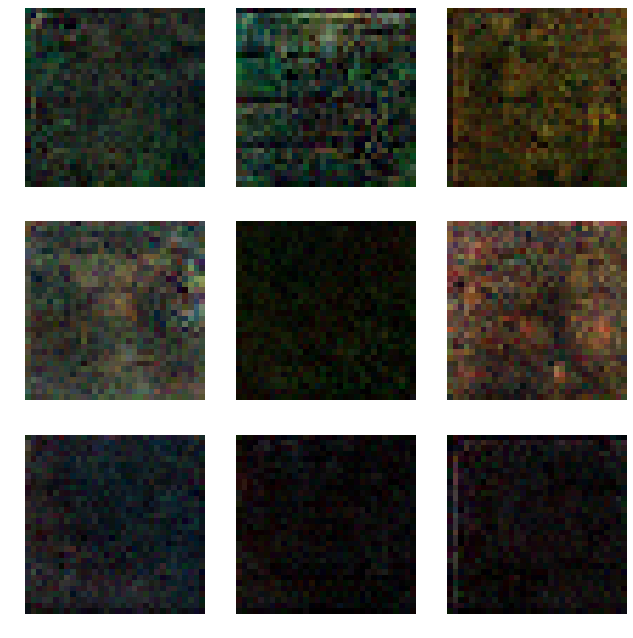

In [85]:
noise = np.random.uniform(-1, 1, size=[batch_size, 100])
plotGeneratedImages()

In [0]:
from google.colab import files
import matplotlib.image as mpimg
import uuid

images = 5
noise = np.random.uniform(-1, 1, size=[images, 100])
generated_images = generator.predict(noise)    
for i in range(images):
  name = str(uuid.uuid4().hex) + '.png'
  img = np.reshape(np.clip(generated_images[i, :],0,1),(32, 32, 4))
  mpimg.imsave(name, img)             
  files.download(name)
